In [1]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

class_names = ['0', '1', '2', '3', 
               '4', '5', '6', '7', 
               '8', '9']
number_of_classes = 10

In [2]:
def rgb_to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

datagen = ImageDataGenerator(
    preprocessing_function=rgb_to_grayscale,
    rescale=1.0/255, 
    validation_split=0.2,
    fill_mode='constant',
    cval=0
)

train_generator = datagen.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=256,
    subset='training',
    class_mode='sparse'
)

validation_generator = datagen.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=256,
    subset='validation',
    class_mode='sparse'
)

input_shape = train_generator[0][0][0].shape

Found 87808 images belonging to 10 classes.
Found 21946 images belonging to 10 classes.


In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(256, (3,3), activation='elu', 
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(512, (1,1), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (1,1), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (1,1), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 12, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 12, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 12, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 12, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 6, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 6, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 6, 256)        2

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.losses.SparseCategoricalCrossentropy(),
                       'accuracy'])

In [6]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('val_accuracy') >= 0.99 and logs.get('accuracy') >= 0.98) :
            print('\nReached 99% accuracy so stopping training')
            self.model.stop_training = True

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='D:\\Code\\AI\\Model\\NumberRecognitionModel\\version5.hdf5',
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True)

In [7]:
callback = stopCallback()

history = model.fit(train_generator, 
                    epochs=1000, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=validation_generator)

Epoch 1/1000
343/343 [==============================] - 181s 527ms/step - loss: 2.4741 - sparse_categorical_crossentropy: 0.3309 - accuracy: 0.9023 - val_loss: 3.7111 - val_sparse_categorical_crossentropy: 1.6242 - val_accuracy: 0.4426
Epoch 2/1000
343/343 [==============================] - 173s 505ms/step - loss: 2.1314 - sparse_categorical_crossentropy: 0.1173 - accuracy: 0.9679 - val_loss: 1.9840 - val_sparse_categorical_crossentropy: 0.0482 - val_accuracy: 0.9857
Epoch 3/1000
343/343 [==============================] - 179s 523ms/step - loss: 1.9492 - sparse_categorical_crossentropy: 0.0984 - accuracy: 0.9728 - val_loss: 1.8023 - val_sparse_categorical_crossentropy: 0.0393 - val_accuracy: 0.9882
Epoch 4/1000
343/343 [==============================] - 202s 589ms/step - loss: 1.7587 - sparse_categorical_crossentropy: 0.0861 - accuracy: 0.9759 - val_loss: 1.6197 - val_sparse_categorical_crossentropy: 0.0386 - val_accuracy: 0.9875
Epoch 5/1000
343/343 [==============================] - 

(0.0, 0.6)

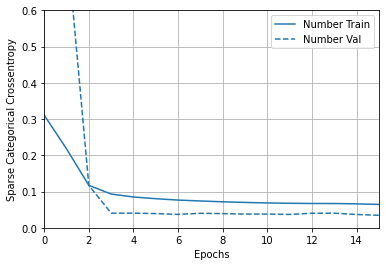

In [8]:
H = {}
H['number'] = history
plotter = tfdocs.plots.HistoryPlotter(metric='sparse_categorical_crossentropy', smoothing_std=10)
plotter.plot(H)
plt.ylim(0, 0.6)